In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from matplotlib.dates import datestr2num
import torch.optim as optim
from sklearn import preprocessing
import math
from scipy.stats import gaussian_kde
from datetime import datetime

In [2]:
RESULT_FILENAME = "entry_results.csv"

# with open(RESULT_FILENAME, "a") as fd:
#     fd.write("time_of_run, ")
#     fd.write("BATCH_SIZE, TRAIN_SPLIT, NUM_FEATURES, NUM_UNITS, NUM_USERS, NUM_EPOCHS, ")
#     fd.write("EPSILON, DELTA, NORMCLIP, SIGMA, RHO, w_map, w_distortion, w_distance, w_density, w_ID, w_loc, ")
#     fd.write("MAP_PARAMS, NUM_GRIDS, ")
#     fd.write("AD_LAYERS, GAP_LAYERS, ")
#     fd.write("PRIVATIZER, ")
#     fd.write("train_a_loss, train_p_loss, ")
#     fd.write("u_estimate_acc, loc_estimate_error, ")
#     fd.write("test_a_loss, signal_map_error, distortion_error, loc_error, density_error")    
#     fd.write("\n")

In [373]:
FILENAME = 'augmented_data.csv'

BATCH_SIZE = 128
TRAIN_SPLIT = 0.8

NUM_FEATURES = 24
NUM_UNITS = 32
NUM_USERS = 9
NUM_EPOCHS = 1

EPSILON = 0.1
DELTA = 0.0001
NORM_CLIP=7.0

SIGMA = 0.0

RHO = 0.9
UTILITY_WEIGHTS = (1,1,1,1)
PRIVACY_WEIGHTS =(1,1)

MAP_PARAMS = 2

NUM_GRIDS = 4

with open(RESULT_FILENAME,"a") as fd:
    fd.write(str(datetime.now()))
    fd.write(", ")
    for elt in [BATCH_SIZE, TRAIN_SPLIT, 
                NUM_FEATURES, NUM_UNITS, NUM_USERS, NUM_EPOCHS, 
                EPSILON, DELTA, NORM_CLIP, SIGMA, RHO, UTILITY_WEIGHTS[0], UTILITY_WEIGHTS[1], 
                UTILITY_WEIGHTS[2], UTILITY_WEIGHTS[3], PRIVACY_WEIGHTS[0], PRIVACY_WEIGHTS[1],
                MAP_PARAMS, NUM_GRIDS]:
        fd.write(str(elt))
        fd.write(", ")

## Load Data

In [4]:
userID = {
'a841f74e620f74ec443b7a25d7569545':0,
'22223276ea84bbce3a62073c164391fd':1,
'510635002cb29804d54bff664cab52be':2,
'7cbc37da05801d46e7d80c3b99fd5adb':3,
'7023889b4439d2c02977ba152d6f4c6e':4,
'8425a81da55ec16b7f9f80c139c235a2':5,
'6882f6cf8c72d6324ba7e6bb42c9c7c2':6,
'1e33db5d2be36268b944359fbdbdad21':7,
'892d2c3aae6e51f23bf8666c2314b52f':8,
}

In [5]:
class ChaniaDataset(Dataset):
    def __init__(self, csv_file, transform=None, normalize=True):
        self.augmented_data = pd.read_csv(csv_file, header=0, usecols = [0]+list(range(2,21))+list(range(22,26)), 
                                          converters={0:lambda x: datestr2num(x)})
        self.userlabels = pd.read_csv(csv_file, header=0, usecols=["iPhoneUID"],converters={"iPhoneUID": lambda x: userID[x]})
        self.transform = transform
        
        if normalize:
            self.augmented_data=(self.augmented_data-self.augmented_data.mean())/self.augmented_data.std()

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        data = self.augmented_data.iloc[idx].values
        data = data.astype('float').reshape(-1,NUM_FEATURES)            
        user = self.userlabels.iloc[idx].values
        user = user.astype('int').reshape(-1,1)
        sample = {'x':data, 'u':user}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [6]:
class ToTensor(object):
    def __call__(self, sample):
        data, user = sample['x'], sample['u']
        return {'x':torch.from_numpy(data), 'u':torch.from_numpy(user)}

In [7]:
chania_dataset = ChaniaDataset(csv_file=FILENAME, transform=ToTensor(), normalize=True)

In [8]:
train_size=int(TRAIN_SPLIT*len(chania_dataset))
test_size = len(chania_dataset)-train_size

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(chania_dataset, [train_size, test_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Visualize Functions

In [303]:
def show_batch_wlabels(sample_batch,longlines=None,latlines=None):
    with torch.no_grad():
        data, users = sample_batch['x'], sample_batch['u']
        batch_size = len(data)
        colors = users.numpy()[:,0].tolist()
        for i in range(batch_size):
            plt.scatter(data[:,:,13].numpy(), data[:,:,12].numpy(), c=colors)
        if longlines is not None:
            for line in longlines.numpy():
                plt.axvline(line)
        if latlines is not None:
            for line in latlines.numpy():
                plt.axhline(line)

In [340]:
def show_privatizer(x, y, u, uhat, lochat):
    with torch.no_grad():
        fig, ax = plt.subplots(1,3,figsize=(15,5))
        #sharex=True,sharey=True,
        ax[0].set_title("Input Data")
        ax[1].set_title("Obfuscated Data")
        ax[2].set_title("Adversary Estimate")
        
        ax[0].scatter(x[:,:,13].numpy(),x[:,:,12].numpy(),c=u.unsqueeze(0).numpy().T.tolist())
        ax[1].scatter(y[:,:,13].numpy(),y[:,:,12].numpy())
        _, upred = torch.max(uhat.data,1)
        ax[2].scatter(lochat[:,1].numpy(), lochat[:,0].numpy(),c=upred.numpy())

In [305]:
def show_maps(x, y,npoints=100):
    with torch.no_grad():
        fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
        ax[0].set_title("Map from Input Data")
        ax[1].set_title("Map from Obfuscated Data")
        
        grid = torch.empty(npoints,1,2).uniform_(5)-2.5
        tr = [grid[:,:,1]**i*grid[:,:,0]**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)]
        poly_grid = torch.cat(tr,1)
        poly_grid = poly_grid.view(-1,6)
        
        bx = signal_map_params(x,MAP_PARAMS).float()
        by = signal_map_params(y,MAP_PARAMS).float()  
        x_predicted_rss = torch.mm(poly_grid,bx)
        y_predicted_rss = torch.mm(poly_grid,by)
        
        ax[0].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=x_predicted_rss.numpy())
        ax[1].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=y_predicted_rss.numpy())

## Define loss and helper functions

In [306]:
def privatizer_loss(x,y,u,uhat):
    bx = signal_map_params(x,MAP_PARAMS)
    by = signal_map_params(y,MAP_PARAMS)
    l1 = (bx-by).pow(2).mean()
    l2 = (x-y).pow(2).mean()
    l3 = (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean()
    cx,_,_ = density_count(x,NUM_GRIDS)
    cy,_,_ = density_count(y,NUM_GRIDS)
    l4 = (cx-cy).pow(2).mean()/BATCH_SIZE
    l = torch.nn.CrossEntropyLoss()
    l5 = l(uhat,u)
    w1,w2,w3,w4 = UTILITY_WEIGHTS
    return RHO*(w1*l1+w2*l2+w3*l3+w4*l4)-(1-RHO)*l5

In [307]:
def poly(degree, long, lat):
    return torch.cat([long**i*lat**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)],1)

def signal_map_params(x,degree):    
    polynomial = poly(MAP_PARAMS, x[:,:,13], x[:,:,12])
    beta = torch.mm(torch.inverse(torch.mm(torch.transpose(polynomial,0,1), polynomial)),
                  torch.mm(torch.transpose(polynomial,0,1), x[:,:,6]))
    return beta

In [308]:
def density_count(x, num_grids):
    count = torch.zeros(num_grids,num_grids)
    x1min=torch.min(x[:,:,13])
    x2min=torch.min(x[:,:,12])
    size1 = torch.max(x[:,:,13])-x1min
    size2 = torch.max(x[:,:,12])-x2min
    a_all = []
    c_all = []
    for i in range(num_grids):
        for j in range(num_grids):
            a = x1min+(size1/num_grids*i)
            a_all.append(a)
            b = x1min+(size1/num_grids*(i+1))
            a_all.append(b)
            c = x2min+(size2/num_grids*j)
            c_all.append(c)
            d = x2min+(size2/num_grids*(j+1))
            c_all.append(d)
            if i == num_grids-1 and j != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
            elif j == num_grids-1 and i != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            elif j == num_grids-1 and i == num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            else:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
    return count, torch.unique(torch.Tensor(a_all)), torch.unique(torch.Tensor(c_all))

In [309]:
def adversary_loss(u,x,uhat,lochat):
    l = torch.nn.CrossEntropyLoss()
    dist = (x[:,:,12:14].squeeze()-lochat).pow(2).mean()
    # spread = (x[:,:,12:14].squeeze().std(dim=0)-lochat.std(dim=0)).pow(2).mean()
    w1, w2 = PRIVACY_WEIGHTS
    return w1*l(uhat,u)+w2*dist

## Define adversary

In [374]:
with open(RESULT_FILENAME, "a") as fd:
    fd.write("3, ")

In [375]:
adversary = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_USERS+2)
)
# adversary.apply(init_weights)
adversary.double()

Sequential(
  (0): Linear(in_features=24, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=11, bias=True)
)

In [376]:
adversary_optimizer = optim.Adam(adversary.parameters(),lr=0.001, betas=(0.9,0.999))

## Define privatizers

#### GAP

In [378]:
with open(RESULT_FILENAME, "a") as fd:
    fd.write("3, ")

In [363]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.25)
        # m.bias.data.fill_(2)

In [377]:
gap_privatizer = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
#     torch.nn.Linear(NUM_UNITS, NUM_UNITS),
#     torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_FEATURES)
)
gap_privatizer.apply(init_weights)
gap_privatizer.double()
gap_privatizer_optimizer = optim.Adam(gap_privatizer.parameters(),lr=0.001, betas=(0.9,0.999))

#### Local DP

In [379]:
def analytical_gaussian_sigma(eta, epsilon, delta):
    def phi(x):
        return 1/2*(1+math.erf(x/math.sqrt(2)))
    delta_0 = phi(0)-math.e**epsilon*phi(-math.sqrt(2*epsilon))
    print(delta_0)
    def Bplus(v):
        return phi(math.sqrt(epsilon*v))-math.e**epsilon*phi(-math.sqrt(epsilon*(v+2)))
    def Bminus(v):
        return phi(-math.sqrt(epsilon*v))-math.e**epsilon*phi(-math.sqrt(epsilon*(v+2)))
    if delta >= delta_0:
        vstar = 0
        while Bplus(vstar) <= delta:
            vstar += 1
            if vstar == 1000000:
                return 0
        alpha = math.sqrt(1+vstar/2)-math.sqrt(vstar/2)
    else:
        ustar = 0
        while Bminus(ustar) > delta:
            ustar += 1
        alpha = math.sqrt(1+ustar/2)+math.sqrt(ustar/2)
    sigma = alpha*eta/math.sqrt(2*epsilon)
    return sigma

def dp_privatizer(x,s):
    normvec = torch.norm(x,p=2,dim=2)
    scalevec = NORM_CLIP/normvec
    scalevec[scalevec>1] = 1
    x = torch.transpose(torch.transpose(x,0,1)*scalevec,0,1).double()
    noise = torch.normal(mean=torch.zeros_like(x),std=s).double()
    y = x + noise
    return y

#### Gaussian Noise

In [380]:
def noise_privatizer(x):
    noise = torch.normal(mean=torch.zeros_like(x),std=SIGMA).double()
    y = x + noise
    return y

### Distribution-based Privatizers

#### Entirely Joint

In [26]:
def entirely_joint_privatizer(x, firstcall=False, PROB_DISTR=None):
    if firstcall:
        prob_distr = gaussian_kde(chania_dataset[:]['x'].numpy().squeeze().T)
        cf = len(chania_dataset)**(-NUM_FEATURES/(1+4))
        prob_distr.covariance_factor = lambda : cf
        prob_distr._compute_covariance()
        PROB_DISTR = prob_distr
    y = PROB_DISTR.resample(128).T
    y = torch.DoubleTensor(y.reshape(BATCH_SIZE,1,NUM_FEATURES))
    return y, PROB_DISTR

#### Semi Joint

In [27]:
def semi_joint_privatizer(x):
    # TODO
    return x

#### Entirely Independent

In [28]:
def independent_privatizer(x):
    # TODO
    return x

# TRAIN

In [381]:
PRIVATIZER = dp_privatizer

In [382]:
with open(RESULT_FILENAME, "a") as fd:
    fd.write(str(PRIVATIZER.__name__))
    fd.write(", ")

In [383]:
sigma = analytical_gaussian_sigma(NORM_CLIP, EPSILON, DELTA)

# for each epoch
for epoch in range(NUM_EPOCHS):
    
    # iterate through the training dataset
    for i, batch in enumerate(train_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        if PRIVATIZER == gap_privatizer:
            # reset privatizer gradients
            gap_privatizer_optimizer.zero_grad()
        
        # privatize x
        if PRIVATIZER == entirely_joint_privatizer:
            if epoch == 0 and i == 0:
                y, PROB_DISTR = entirely_joint_privatizer(x,firstcall=True)
            else:
                y, _ = entirely_joint_privatizer(x, PROB_DISTR)
                
        elif PRIVATIZER == dp_privatizer:
            y = dp_privatizer(x,sigma)
        else:
            y = PRIVATIZER(x)
        
        # reset adversary gradients
        adversary_optimizer.zero_grad()
        
        # estimate userIDs and original locations
        estimate = adversary(y).squeeze()
        uhat, lochat = estimate[:,:9], estimate[:,9:]
        
        # train adversary
        aloss = adversary_loss(u,x,uhat,lochat)
        aloss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(adversary.parameters(), 1000)
        adversary_optimizer.step()
        
        # evaluate utility loss
        ploss = privatizer_loss(x,y,u,uhat)
        
        if PRIVATIZER == gap_privatizer:
            # train privatizer
            ploss.backward()
            # check that gradients are non-zero
            # for param in gap_privatizer.parameters():
                # print(param.grad)
            torch.nn.utils.clip_grad_norm_(gap_privatizer.parameters(), 1000)
            gap_privatizer_optimizer.step()
        
        # print progress
        if i % 1000 == 999:
            print(i+1,"aloss:",aloss.item(),"ploss:",ploss.item())
          
        # stop early
        if i == 1000:
            pass
print("done")

with torch.no_grad():
    with open(RESULT_FILENAME, "a") as fd:
        fd.write(str(aloss.item()))
        fd.write(", ")
        fd.write(str(ploss.item()))
        fd.write(", ")

0.1382107807611922
1000 aloss: 2.697778254332256 ploss: 52948.66863104899
2000 aloss: 2.6128159163839677 ploss: 54836.30690531454
done


# Test

In [384]:
# do not keep track of gradients
with torch.no_grad():
    correct = 0
    total = 0
    dist_error = 0
    l1,l2,l3,l4,l5 = 0,0,0,0,0
    
    # iterate through test data
    for i,batch in enumerate(test_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        # privatize x
        if PRIVATIZER == entirely_joint_privatizer:
            y, _ = entirely_joint_privatizer(x, PROB_DISTR)
        elif PRIVATIZER == dp_privatizer:
            y = dp_privatizer(x,sigma)
        else:
            y = PRIVATIZER(x)
        
        # estimate userID and location
        estimate = adversary(y).squeeze()
        uhat, lochat = estimate[:,:9], estimate[:,9:]
        
        # Privacy Metric
        _, upred = torch.max(uhat.data,1)
        total+=u.size(0)
        correct+=(upred==u).sum().item()
        dist_error += (x[:,:,12:14].squeeze()-lochat).pow(2).mean().item()
        
        # Utility Metrics
        l = torch.nn.CrossEntropyLoss()
        l5 += l(uhat,u).item()
        bx = signal_map_params(x,MAP_PARAMS)
        by = signal_map_params(y,MAP_PARAMS)
        l1 += (bx-by).pow(2).mean().item()
        l2 += (y-x).pow(2).mean().item()
        l3 += (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean().item()
        cx,_,_ = density_count(x,NUM_GRIDS)
        cy,_,_ = density_count(y,NUM_GRIDS)
        l4 += (cx-cy).pow(2).mean().item()/BATCH_SIZE
        
        # stop early
        if i==1:
            break
            
    if PRIVATIZER == gap_privatizer:
        print("RHO=",RHO)
    elif PRIVATIZER == noise_privatizer:
        print("SIGMA=",SIGMA)
    elif PRIVATIZER == dp_privatizer:
        print("EPSILON=",EPSILON,"DELTA=",DELTA,"NORM_CLIP=",NORM_CLIP)
    print("")
        
    print("Adversary Accuracy:", 100*correct/total)
    print("Average estimated location error:",dist_error/(i+1))
    print("")
    
    print("Adversary Loss:", l5/(i+1))
    print("Sigmal Map:", l1/(i+1))
    print("Distortion:", l2/(i+1))
    print("Geographic Distortion:", l3/(i+1))
    print("Density Count:",l4/(i+1))
    
    with open(RESULT_FILENAME, "a") as fd:
        for elt in [100*correct/total, dist_error/(i+1), l5/(i+1), l1/(i+1), l2/(i+1), l3/(i+1)]:
            fd.write(str(elt))
            fd.write(", ")
        fd.write(str(l4/(i+1)))
        fd.write("\n")

EPSILON= 0.1 DELTA= 0.0001 NORM_CLIP= 7.0

Adversary Accuracy: 32.03125
Average estimated location error: 0.8447150265935637

Adversary Loss: 1.7540873745721783
Sigmal Map: 3.665793832943619
Distortion: 29206.896627603226
Geographic Distortion: 31480.283091524405
Density Count: 2.0498046875


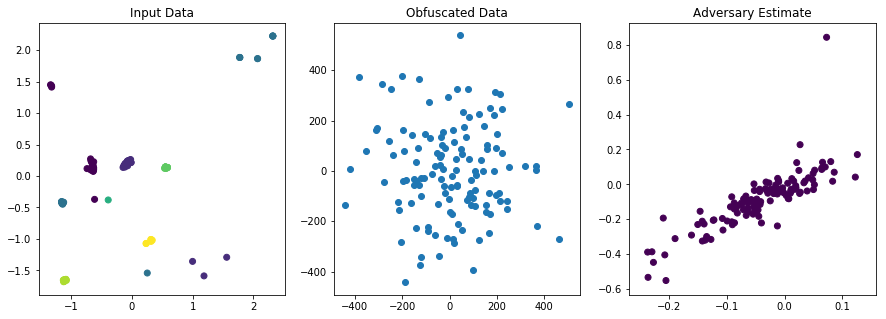

In [385]:
show_privatizer(x,y,u,uhat,lochat)

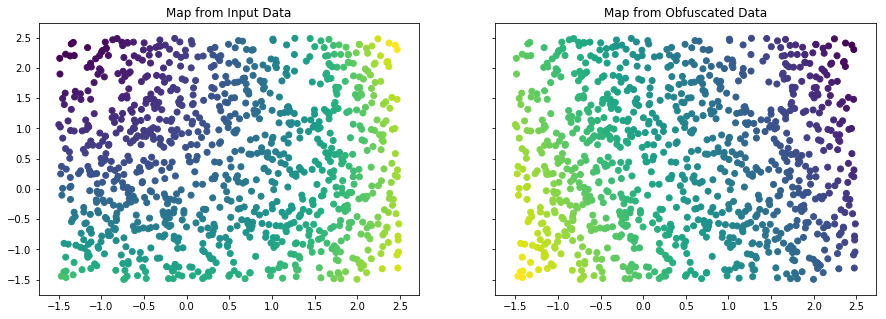

In [386]:
show_maps(x,y,1000)

In [31]:
# with open(RESULT_FILENAME, "a") as fd:
#     fd.write("\n")